**VGG16**

**Dataset**

Dataset used is the CEDAR Signature Dataset 

Dataset Link :     [CEDAR](http://www.cedar.buffalo.edu/NIJ/data/signatures.rar)

In [1]:
!wget -N -P . http://www.cedar.buffalo.edu/NIJ/data/signatures.rar

--2022-06-08 16:22:56--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2022-06-08 16:22:57--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./signatures.rar’ not modified on server. Omitting download.



In [2]:
!unrar x -inul signatures.rar

In [1]:
import tensorflow
import tensorflow as tf
from tensorflow import keras
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tensorflow.__version__)
print(keras.__version__)
print(pd.__version__)
print(cv2.__version__)
print(np.__version__)

2.9.1
2.9.0
1.4.2
4.5.5
1.21.5


**DataFrame Generator**

Generates a pandas dataframe with path of the signature samples that are used in this model.

Total Samples = Number of Persons * Number of Samples * (2)

          Total Samples    = 55 * 24 * 2 = 2640 

In [2]:
path_org =  'signatures/full_org'
path_forg = 'signatures/full_forg'
no_persons = 55
no_signs = 24

def create_df():
  org_sign = []
  lst_1 =[]
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_org+'/original_'+str(i)+'_'+str(j)+'.png')
      org_sign.append(path)
      lst_1.append(1)

  forg_sign = []
  lst_2=[]
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_forg+'/forgeries_'+str(i)+'_'+str(j)+'.png')
      forg_sign.append(path)
      lst_2.append(0)
  
  raw_data = {"input":[], "label":[]}
  raw_data["input"]=org_sign + forg_sign
  raw_data["label"]=lst_1 + lst_2

  df = pd.DataFrame(raw_data, columns = ["input","label"])
  return df


**Dataset Split**

Splitting the data into train, validation and test data with a ratio  6:2:2

Train data = 0.6 * 2640 = 1584

Validation data = 0.4 * 0.5 * 2640 = 528

Testing data = 0.4 * 0.5 * 2640 = 528


In [3]:
def train_test_dataset():
  data_frame = create_df()
  train_set, res_set = train_test_split(data_frame,train_size=0.6,random_state=0)
  validation_set, test_set = train_test_split(res_set,train_size=0.5,random_state=0)

  return train_set, validation_set, test_set

train_set,validation_set, test_set = train_test_dataset()
print(train_set.size, validation_set.size, test_set.size)
print("The number of instances in train set",train_set.shape[0])
print("The number of instances in validation set",validation_set.shape[0])
print("The number of instances in test set",test_set.shape[0])

3168 1056 1056
The number of instances in train set 1584
The number of instances in validation set 528
The number of instances in test set 528


**Processing The Signatures**


In [4]:
def sig_process(inp):
  
  inp = cv2.resize(inp,(224,224))
  inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
  ret,inp = cv2.threshold(inp, 0, 255, cv2.THRESH_OTSU)
  inp = inp/255
  inp = inp[:, :, np.newaxis]
  inp = np.array(inp)

  return inp

**Input Generator for the Model**

In [5]:
class generate(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size, dimension):
        self.dimension = dimension
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]

        self.on_epoch_end()
    
    def __len__(self):
        s_df=self.df.shape[0]
        n=np.floor(s_df/self.batch_size)
        return int(n)

    def __getitem__(self, ind):
        batches = self.indices[ind*self.batch_size:(ind+1)*self.batch_size]
        items = [self.df.iloc[k] for k in batches]
        part1 = self.generator(items)
        return part1

    def on_epoch_end(self):
        self.indices = np.arange(self.df.shape[0])

    def generator(self, items):
        part_1 = np.empty((self.batch_size, *self.dimension,1))
        label = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(items)):

            input_1 = cv2.imread(items[i]["input"])
            input_1 = sig_process(input_1) 

            label[i] = items[i]["label"]
            part_1[i,] = input_1
            
        return [part_1], label

In [6]:
dimension = (224,224)
batch_size = 32
data_training = generate(train_set,batch_size,dimension)
data_validation = generate(validation_set,batch_size,dimension)
data_testing = generate(test_set,batch_size,dimension)

**Functions Used**

In [7]:
from tensorflow.keras import backend as K

def output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
    
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

**VGG16 Training Model**

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import sigmoid
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras import applications

def vgg_model():
  
  input_shape=(224,224,1)  
  input_1 = Input(shape=input_shape, name="input")   
  input_conc = Concatenate()([input_1, input_1, input_1])  
  base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_conc)
  base_model.summary()
    
    
  ex_model = Sequential()
  ex_model.add(Flatten(input_shape=base_model.output_shape[1:]))
  ex_model.add(Dense(64, activation='relu'))
  ex_model.add(Dense(1, activation='sigmoid'))

  model = Model(inputs=base_model.input, outputs=ex_model(base_model.output))

  model.summary()
  plot_model(model, to_file='sequential.png', show_shapes=True, show_layer_names=True)

  return model

In [10]:
model = vgg_model()

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 224, 224, 3)  0           ['input[0][0]',                  
                                                                  'input[0][0]',                  
                                                                  'input[0][0]']                  
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate_1[0][0]']      

In [11]:
#img = cv2.imread('sequential_model.png')
#print("The Layers in Sequential API are \n")
#cv2_imshow(img)

**Training the Model**

In [12]:
from tensorflow.keras.optimizers import Adam
adam = tf.keras.optimizers.Adam(learning_rate = 3e-4, epsilon = 1e-08)
model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics =['accuracy'])

In [14]:
history=model.fit(data_training, validation_data = data_validation, epochs= 50)

Epoch 1/50
49/49 [==============================] - 58s 1s/step - loss: 0.8138 - accuracy: 0.5038 - val_loss: 0.7201 - val_accuracy: 0.5059
Epoch 2/50
49/49 [==============================] - 57s 1s/step - loss: 0.7018 - accuracy: 0.5370 - val_loss: 0.6545 - val_accuracy: 0.6934
Epoch 3/50
49/49 [==============================] - 57s 1s/step - loss: 0.6454 - accuracy: 0.6403 - val_loss: 0.5979 - val_accuracy: 0.6562
Epoch 4/50
49/49 [==============================] - 57s 1s/step - loss: 0.5982 - accuracy: 0.6926 - val_loss: 0.5688 - val_accuracy: 0.7227
Epoch 5/50
49/49 [==============================] - 58s 1s/step - loss: 0.5431 - accuracy: 0.7245 - val_loss: 0.5643 - val_accuracy: 0.7129
Epoch 6/50
49/49 [==============================] - 58s 1s/step - loss: 0.5091 - accuracy: 0.7487 - val_loss: 0.5258 - val_accuracy: 0.7422
Epoch 7/50
49/49 [==============================] - 58s 1s/step - loss: 0.4714 - accuracy: 0.7742 - val_loss: 0.5171 - val_accuracy: 0.7422
Epoch 8/50
49/49 [==

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 224, 224, 3)  0           ['input[0][0]',                  
                                                                  'input[0][0]',                  
                                                                  'input[0][0]']                  
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate_1[0][0]']    

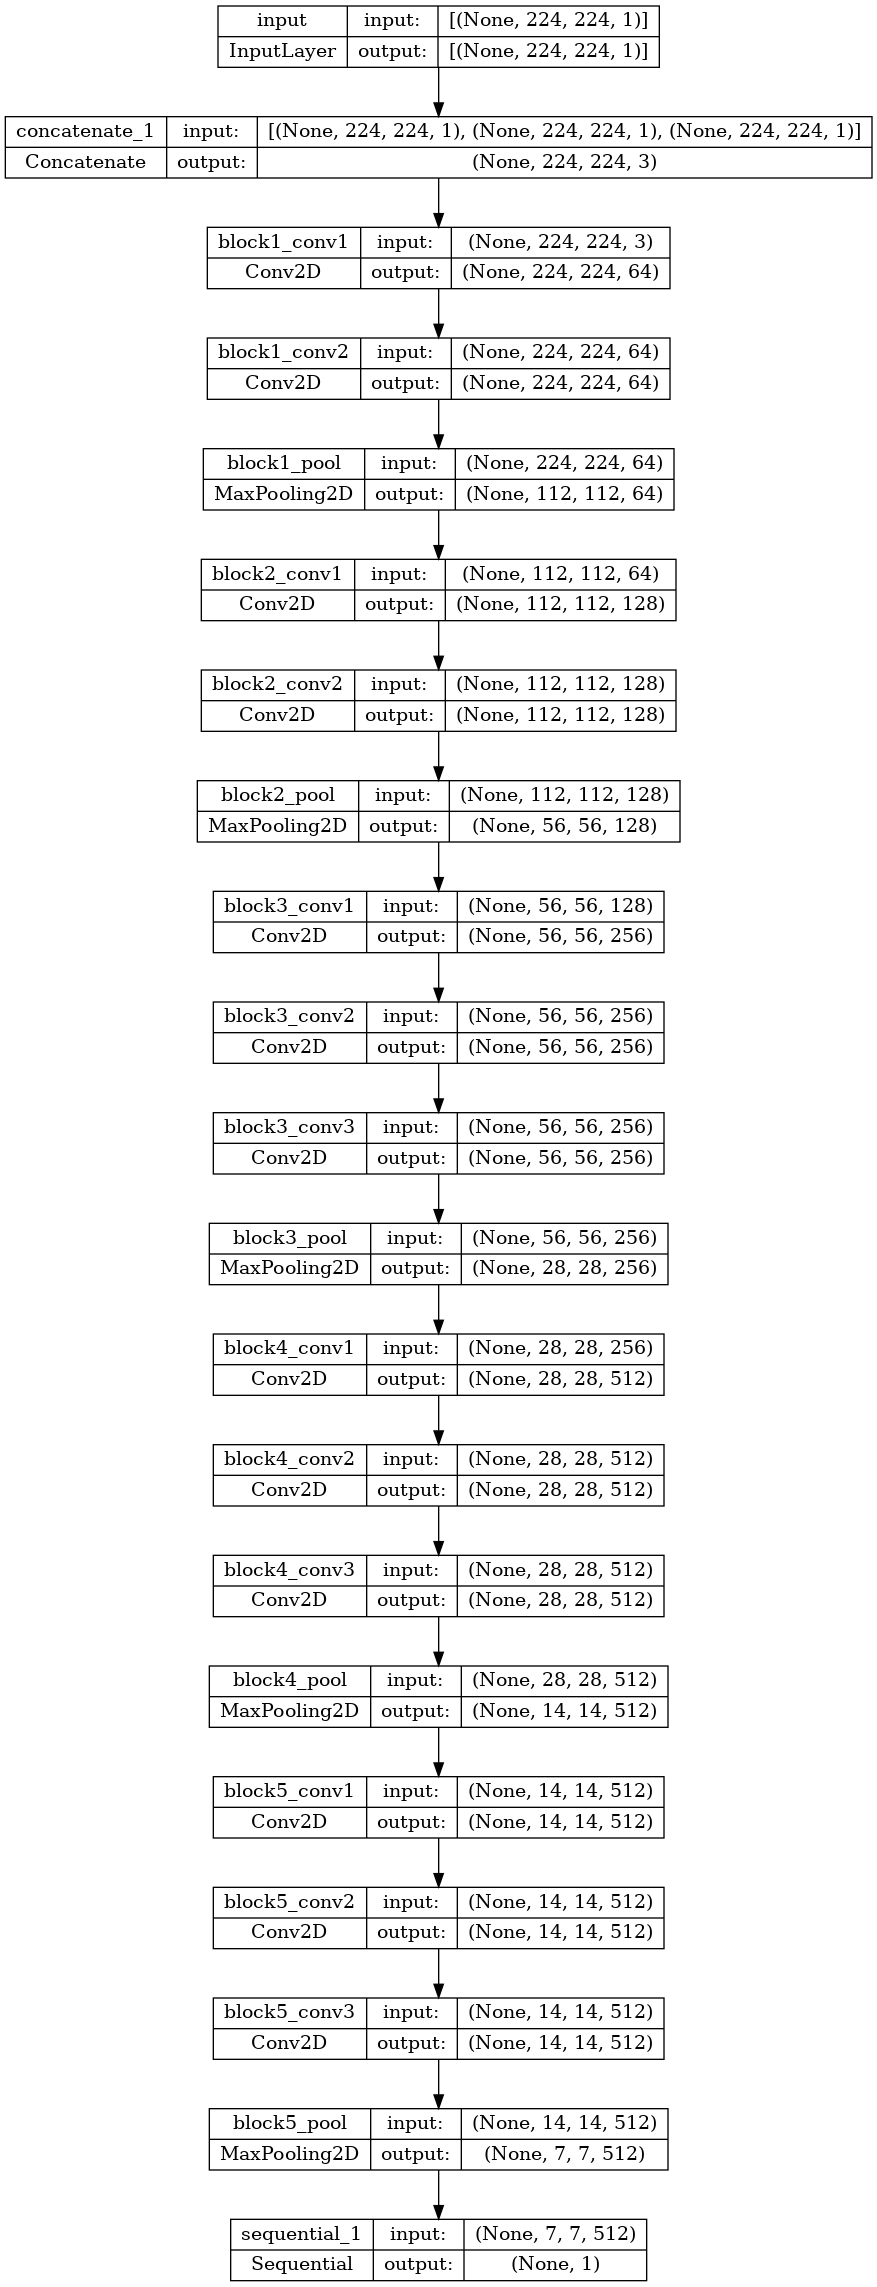

In [15]:
model.summary()
print("The layers in the VGG Model are \n")
tf.keras.utils.plot_model(model, to_file="base_model.png", show_shapes=True)

In [16]:
model.save('vgg.h5')

**Plotting graphs for Accuracy and Loss**

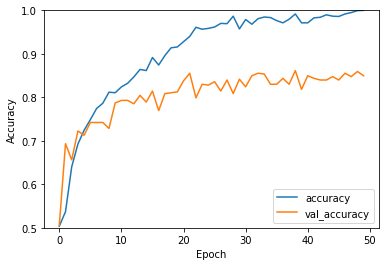

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("accuracy_plot.png")

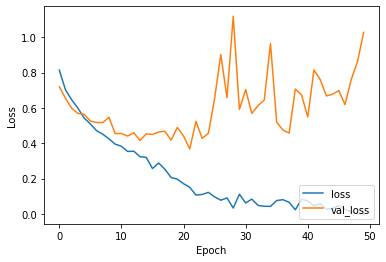

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("loss_plot.png")

**Evaluating the validation accuracy and Validation loss**

In [19]:
validation_loss, validation_acc = model.evaluate(data_validation)

16/16 [==============================] - 5s 312ms/step - loss: 1.0270 - accuracy: 0.8496


In [20]:
print("The validation loss is = ",validation_loss)

The validation loss is =  1.027029037475586


In [21]:
print("The validation accuracy is = ",validation_acc)

The validation accuracy is =  0.849609375


**Evaluating the Test accuracy and Test loss**

In [22]:
test_loss, test_acc = model.evaluate(data_testing)

16/16 [==============================] - 5s 311ms/step - loss: 1.1274 - accuracy: 0.8359


In [23]:
print("The testing loss is = ",test_loss)

The testing loss is =  1.1274317502975464


In [24]:
print("The testing accuracy is = ",test_acc)

The testing accuracy is =  0.8359375


In [36]:
print('\n Test Signature Details : \n')
type=input('Enter forg for forged and org for genuine signature : ')
s = input('Enter signer number(1 to 55) : ')
s2=input('Enter signature number for signer number '+s+'(1 to 24) : ') 

if(type=='forg'):
  st='forgeries'
elif(type=='org'):
  st='original'

inp = cv2.imread('signatures/full_'+type+'/'+st+'_'+s+'_'+s2+'.png')

inp = sig_process(inp)
                   
inp = np.expand_dims(inp,axis=0)

inp_pred = model.predict([inp])
inp_pred = np.round(inp_pred)

print(inp_pred)

if (inp_pred[0][0] == 0):
  print('The signature is genuine \n')
elif(inp_pred[0][0]>=1):
  print('The signature is forged \n')



 Test Signature Details : 



Enter forg for forged and org for genuine signature :  org
Enter signer number(1 to 55) :  22
Enter signature number for signer number 22(1 to 24) :  22


1/1 [==============================] - 0s 14ms/step
[[1.]]
The signature is forged 

